In [440]:
import pandas as pd, numpy as np, regex as re, sklearn as sk, matplotlib.pyplot as plt, urllib
from urllib.parse import urlparse
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import MultinomialNB 
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report as score, confusion_matrix, accuracy_score
import seaborn as sns; sns.set()
from sklearn.model_selection import GridSearchCV
import inspect

In [187]:
# Import csv
df_orig = pd.read_csv('C:/Users/dmitr/Documents/Work/Projects/Kaggle/MBTI/mbti.csv',header = 0)

In [188]:
# Replace | with whitespace
df_orig.posts = df_orig.posts.replace('\|',' ',regex = True)

In [189]:
# Replace unique URLs with generic URLs

f1 = lambda arg: ' '.join([urlparse(x).netloc if any(s in x for s in ['http','www.']) else x for x in arg.split()])
df_orig['posts2'] = df_orig['posts'].apply(f1)

In [190]:
df_orig[['posts','posts2']] = df_orig[['posts','posts2']].replace('\'','',regex = True)

In [191]:
# Remove any extra white space

df_orig = df_orig.apply(lambda x: x.str.replace(' +',' '), axis = 1)

In [192]:
# Quantify differences of manipulated URLs vs unmanipulated URLs

df_orig['len1'] = df_orig['posts'].str.len()
df_orig['len2'] = df_orig['posts2'].str.len()
df_orig['length_difference'] = df_orig['len1'] - df_orig['len2']

In [193]:
# Confirm no unnecessary ommissions were made in data manipulations by identifying words in list 1 that do not exist in list 2

df_orig['word_diff'] = df_orig.posts.map(str.split).map(set) - df_orig.posts2.map(str.split).map(set)
df_orig['word_diff'] = df_orig['word_diff'].str.join(' ')

In [194]:
# What words outside of URLs fell into our bucket accidentally?

df_orig['word_diff2'] = df_orig['word_diff'].map(lambda x: ' '.join([i for i in x.split() if not any(x in i for x in ['http','www.'])]))

In [195]:
# Remove all non alpabetic non numeric characters and lower case everything

df_ref = df_orig[['type','posts2']].replace('[^a-zA-Z0-9 -]',' ',regex = True)
df_ref['posts2'] = df_ref['posts2'].str.lower()
print(type(df_ref))
df_ref.head()

<class 'pandas.core.frame.DataFrame'>


,type,posts2
0,INFJ,41 media tumblr com enfp and intj moments www...
1,ENTP,im finding the lack of me in these posts very ...
2,INTP,good one www youtube com of course to w...
3,INTJ,dear intp i enjoyed our conversation the othe...
4,ENTJ,youre fired thats another silly misconception...


In [196]:
df_ref['type1'] = df_ref.type.str.slice(0,1)
df_ref['type2'] = df_ref.type.str.slice(1,2)
df_ref['type3'] = df_ref.type.str.slice(2,3)
df_ref['type4'] = df_ref.type.str.slice(3,4)

print(df_ref[['type1','type2','type3','type4']].head())

  type1 type2 type3 type4
0     I     N     F     J
1     E     N     T     P
2     I     N     T     P
3     I     N     T     J
4     E     N     T     J


type
ENFJ     190
ENFP     675
ENTJ     231
ENTP     685
ESFJ      42
ESFP      48
ESTJ      39
ESTP      89
INFJ    1470
INFP    1832
INTJ    1091
INTP    1304
ISFJ     166
ISFP     271
ISTJ     205
ISTP     337
Name: type, dtype: int64


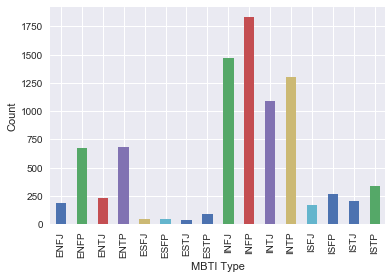

In [197]:
# Looks like we're dealing with many more introverts than extroverts, go figure introverts would end up undergoing MBTI and actively contributing content on the internet ;)
# Interestingly enough the highest dist of extroverts are ENFPs which are known as the most introverted extroverts and ENTP which are very closely related in temperament to ENFPs 
df_ref.groupby('type')['type'].count().plot(kind = 'bar')
plt.ylabel('Count')
plt.xlabel('MBTI Type')
print(df_ref.groupby('type')['type'].count())

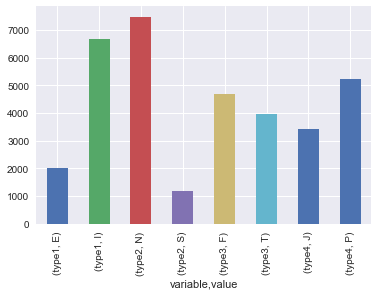

In [198]:
# Looks like we are dealing with mostly introverts and disproportionately intuitive type rather than Sensing type

df_ref[['type1','type2','type3','type4']].melt().groupby(['variable','value'])['value'].count().plot(kind = 'bar')

In [199]:
# Split data into train and test

x_train, x_test, y_train, y_test = train_test_split(df_ref['posts2'], df_ref[['type','type1','type2','type3','type4']], test_size = 0.2, random_state = 123)
print(x_train.shape,y_train.shape)

(6940,) (6940, 5)


pandas.core.frame.DataFrame

In [573]:
# Pipeline the process

text_clf = Pipeline(steps = [
    ('vect', CountVectorizer(stop_words = 'english', ngram_range = (1, 2), min_df = 40)),
    ('fit', TfidfTransformer(use_idf = False, norm = None)), #use_idf = False produces greqiencies instead inverse-document-frequency reweighting., None for no normalization.
    ('clf', MultinomialNB()),    
])

In [576]:
# Grid search optimal parameters and predict

parameters = {'vect__min_df':list(np.arange(30,50)),
             }
gs_clf = GridSearchCV(text_clf, parameters, n_jobs = -1)


In [575]:
# Predict and eExpress optimal Parameters
predict = gs_clf.fit(x_train, y_train['type']).predict(x_test)

for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, gs_clf.best_params_[param_name]))
print(gs_clf.best_score_)

AttributeError: 'GridSearchCV' object has no attribute 'best_params_'

In [389]:
# Summarize accuracy 

actual = np.array(y_test['type'])
print(score(actual, predict, labels = list(set(pred))))
print(accuracy_score(actual, predict))

             precision    recall  f1-score   support

       ESFP       0.00      0.00      0.00        11
       ISTJ       0.74      0.36      0.48        39
       INTJ       0.64      0.66      0.65       220
       INTP       0.64      0.65      0.64       286
       ENTP       0.45      0.59      0.51       132
       ISFP       0.27      0.25      0.26        48
       ISFJ       0.44      0.31      0.36        26
       INFP       0.59      0.68      0.63       385
       ENFP       0.54      0.61      0.57       153
       ISTP       0.52      0.38      0.44        66
       ENFJ       0.64      0.19      0.29        37
       ESFJ       0.00      0.00      0.00         7
       INFJ       0.63      0.61      0.62       253
       ENTJ       0.46      0.38      0.42        50

avg / total       0.58      0.58      0.57      1713

0.577521613833


In [428]:
# Vectorize using grid search parameters

my_min_df = gs_clf.best_params_['vect__min_df']
my_ngram_range = gs_clf.best_params_['vect__ngram_range']

cv = CountVectorizer(min_df = my_min_df, stop_words = 'english', ngram_range  = my_ngram_range)
a = cv.fit_transform(x_train).toarray()

In [429]:
print(a)
cv.get_feature_names()[10000:10010]

[[0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 1 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]]


['think fits',
 'think fun',
 'think funny',
 'think going',
 'think good',
 'think got',
 'think great',
 'think guys',
 'think hard',
 'think having']

In [430]:
# Sum down every column of the matrix where fields are represented by words and the column's sum is representative 
# of word's prevalence within all documents

a1 = pd.DataFrame(np.sum(a, axis = 0))
a1.columns = ['word_count']
a1.index.name = ['word_index']
a1.head()

,word_count
[word_index],
0,158
1,235
2,2167
3,70
4,89


In [566]:
# Properties of count of words given my parameters

a1.describe()

,word_count
count,11415.000000
mean,360.798598
std,1536.885712
min,45.000000
25%,64.000000
50%,99.000000
75%,216.000000
max,64168.000000


In [567]:
# Seperate into bins for plot

y1, y2, y3, y4, y5 = a1.describe().loc[['min','25%','50%','75%','max'],'word_count']

binsv = [y1, y2, y3, y4, np.mean([y4,y5]) * .05, np.mean([y4,y5]) * .15, np.mean([y4,y5]) * .20, float("inf")]
a2 = pd.cut(a1.word_count, bins = binsv)

a2.head(15)

[word_index]
0        (99.0, 216.0]
1      (216.0, 1609.6]
2     (1609.6, 4828.8]
3         (64.0, 99.0]
4         (64.0, 99.0]
5      (216.0, 1609.6]
6      (216.0, 1609.6]
7         (45.0, 64.0]
8         (45.0, 64.0]
9         (45.0, 64.0]
10       (99.0, 216.0]
11        (64.0, 99.0]
12     (216.0, 1609.6]
13     (216.0, 1609.6]
14        (64.0, 99.0]
Name: word_count, dtype: category
Categories (7, interval[float64]): [(45.0, 64.0] < (64.0, 99.0] < (99.0, 216.0] < (216.0, 1609.6] < (1609.6, 4828.8] < (4828.8, 6438.4] < (6438.4, inf]]

                  quantity
word_count                
(45.0, 64.0]          2836
(64.0, 99.0]          2828
(99.0, 216.0]         2836
(216.0, 1609.6]       2429
(1609.6, 4828.8]       303


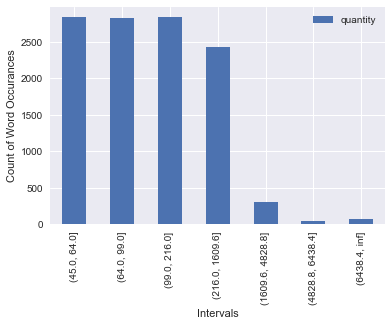

In [568]:
# Find frequencies with which counts of words occur and map them in intervals

a3 = pd.DataFrame(a2.groupby(a2,).count())
a3.columns = ['quantity']

print(a3.head())

a3.plot(kind = 'bar')
plt.xlabel('Intervals')
plt.ylabel('Count of Word Occurances')

In [555]:
y_train[:10]

,type,type1,type2,type3,type4
1000,ISFJ,I,S,F,J
7574,ISFJ,I,S,F,J
995,ENFP,E,N,F,P
4410,INFJ,I,N,F,J
5294,ISTP,I,S,T,P
6710,ESFJ,E,S,F,J
1673,INTP,I,N,T,P
494,INTP,I,N,T,P
4673,INFJ,I,N,F,J
4551,INFJ,I,N,F,J


In [569]:
# Create Confusion Matrix of Actual vs Predicted 

pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'], margins=True)

Predicted,ENFJ,ENFP,ENTJ,ENTP,ESFJ,ESFP,INFJ,INFP,INTJ,INTP,ISFJ,ISFP,ISTJ,ISTP,All
Actual,,,,,,,,,,,,,,,
ENFJ,5,8,0,1,0,0,11,8,2,1,0,1,0,0,37
ENFP,0,89,1,9,1,1,14,29,4,4,0,1,0,0,153
ENTJ,1,4,13,7,0,0,1,2,12,9,0,0,0,1,50
ENTP,0,6,0,75,0,0,8,7,13,23,0,0,0,0,132
ESFJ,0,1,0,1,0,0,3,1,0,0,1,0,0,0,7
ESFP,0,2,0,3,0,0,1,2,1,1,0,1,0,0,11
ESTJ,0,1,0,0,0,0,0,1,2,1,0,0,0,0,5
ESTP,0,3,0,6,0,0,3,1,1,0,0,0,0,3,17
INFJ,1,2,1,12,1,0,158,55,11,8,1,3,0,0,253


In [558]:
def myplt(x,y):
    mat = confusion_matrix(actual, pred)
    plt.figure(figsize = (16,7))
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=True,
                xticklabels=x, yticklabels=y, linewidths=.5)
    plt.xlabel('true label')
    plt.ylabel('predicted label')


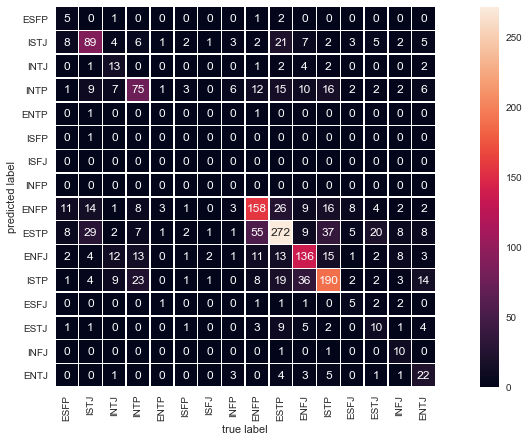

In [559]:
myplt(set(df_orig.type),set(df_orig.type))

             precision    recall  f1-score   support

          E       0.56      0.68      0.62       412
          I       0.89      0.83      0.86      1323

avg / total       0.82      0.80      0.80      1735



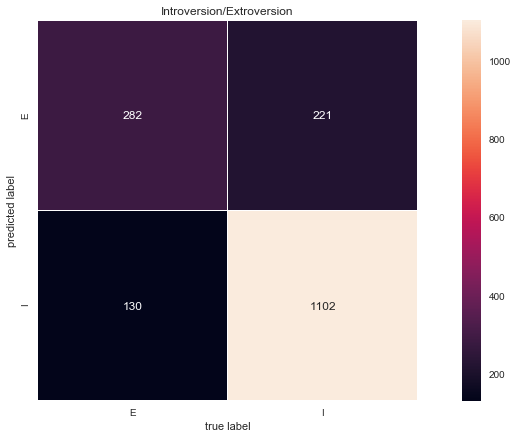

In [583]:
# Predict Introversion/Extroversion

pred = text_clf.fit(x_train, y_train['type1']).predict(x_test)

actual = np.array(y_test['type1'])
print(score(actual, pred, labels = list(set(pred))))

myplt(set(pred),set(pred))
plt.title('Introversion/Extroversion')

             precision    recall  f1-score   support

          S       0.51      0.63      0.57       219
          N       0.95      0.91      0.93      1516

avg / total       0.89      0.88      0.88      1735



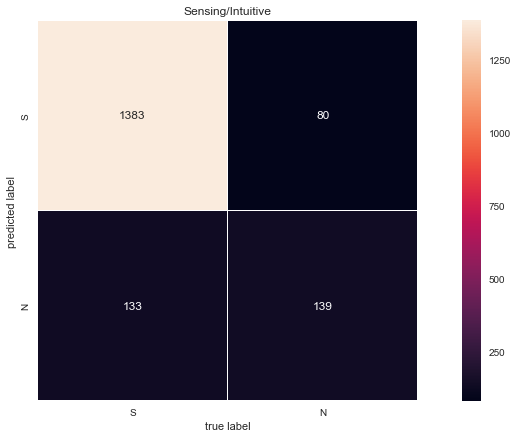

In [584]:
# Predict Sensing/Intuitive

pred = text_clf.fit(x_train, y_train['type2']).predict(x_test)

actual = np.array(y_test['type2'])
print(score(actual, pred, labels = list(set(pred))))

myplt(set(pred),set(pred))
plt.title('Sensing/Intuitive')

             precision    recall  f1-score   support

          F       0.86      0.83      0.85       920
          T       0.82      0.85      0.84       815

avg / total       0.84      0.84      0.84      1735



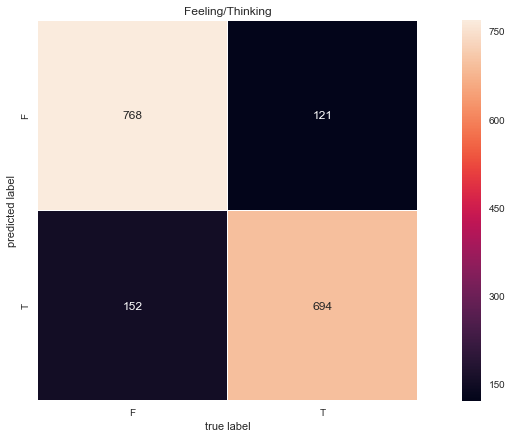

In [585]:
# Predict Feeling/Thinking

pred = text_clf.fit(x_train, y_train['type3']).predict(x_test)

actual = np.array(y_test['type3'])
print(score(actual, pred, labels = list(set(pred))))

myplt(set(pred),set(pred))
plt.title('Feeling/Thinking')

             precision    recall  f1-score   support

          P       0.84      0.81      0.82      1098
          J       0.69      0.73      0.71       637

avg / total       0.78      0.78      0.78      1735



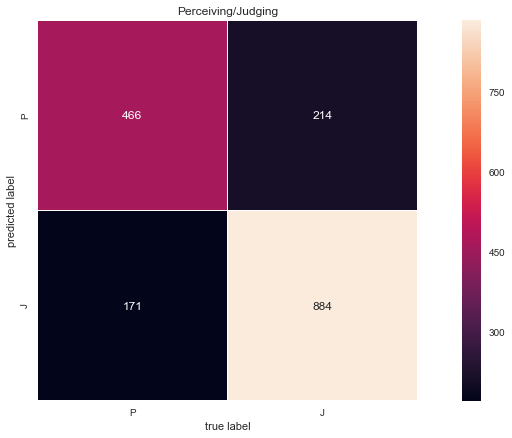

In [586]:
# Predict Perceiving/Judging

pred = text_clf.fit(x_train, y_train['type4']).predict(x_test)

actual = np.array(y_test['type4'])
print(score(actual, pred, labels = list(set(pred))))

myplt(set(pred),set(pred))
plt.title('Perceiving/Judging')